In [8]:
# Setup Environment
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

print(f"Version: {torch.__version__}, GPU: {torch.cuda.is_available()}, NUM_GPU: {torch.cuda.device_count()}")

Version: 2.9.1+cu128, GPU: True, NUM_GPU: 1


In [9]:
# build tokenizer
import tokenizers
from tokenizers import normalizers
from tokenizers import pre_tokenizers
from tokenizers import trainers

import os

def process_files_for_tokenizer(files):
    temp_directory = "temp_files"
    os.makedirs(temp_directory, exist_ok=True)
    outfiles = []
    for file in files:
        outname = os.path.join(temp_directory, os.path.basename(file))
        with open(file, "r") as file_in, open(outname, "w") as file_out:
            raw_data = file_in.read()
            allocation_sites = raw_data.split("\n")
            for site in allocation_sites:
                elements = site.split(">|<")
                if len(elements) < 4:
                    continue
                new_content = "\n".join(elements[3:])
                file_out.write(new_content + "\n")
        outfiles.append(outname)
    return outfiles

def build_tokenizer(files):
    normalizer = normalizers.BertNormalizer()
    pre_tokenizer = pre_tokenizers.Split(tokenizers.Regex("::|,|\\(|\\)|\\n"), "isolated")
    tok_model = tokenizers.models.BPE(unk_token="[UNK]")
    tok_result = tokenizers.Tokenizer(tok_model)
    tok_result.normalizer = normalizer
    tok_result.pre_tokenizer = pre_tokenizer
    trainer = trainers.BpeTrainer(
        vocab_size=5000,
        min_frequency=2,
        special_tokens=["[UNK]"]
    )
    tok_result.train(process_files_for_tokenizer(files), trainer)
    tok_result.save("tokenizer.json")


['']
['']
['']
['']
['']
Snapshot of data:  ((tensor([110,  46, 194,  46, 811,   3,   4,  15,   0,  14, 234,   3,   4,  15,
          0,  14,  87,  46, 231,  46, 248,  46, 428,   3,   4,  15,   0,  14,
         87,  46, 231,  46, 248,  46, 812,   3,   4,  15,   0,  14, 565, 223,
         15,   0,  14, 110,  46, 467,  46, 743,   3,   4,  15,   0,  14, 110,
         46,   3, 287,   4,  46, 263,  46, 440,   3,   4,  15,   0,  14,  63,
         46,  57,  46, 185,   3,   4,  15,   0,  14,  63,  46,  57,  46, 183,
          3,   4,  15,   0,  14,  63,  46,  52,  46, 113,   3,   4,  15,   0,
         14,  63,  46, 324,  46, 113,   3,   4,  15,   0,  14,  63,  46, 321,
         46, 113,   3,   4,  15,   0,  14,  63,  46,  57,  46, 202,  46, 252,
          3,   4,  15,   0,  14,  63,  46,  57,  46, 185,   3,   4,  15,   0,
         14,  63,  46,  57,  46, 183,   3,   4,  15,   0,  14,  63,  46, 148,
         46, 113,   3,   4,  15,   0,  14, 245,   3,   4,  15,   0,  14,  30,
        150,  15, 

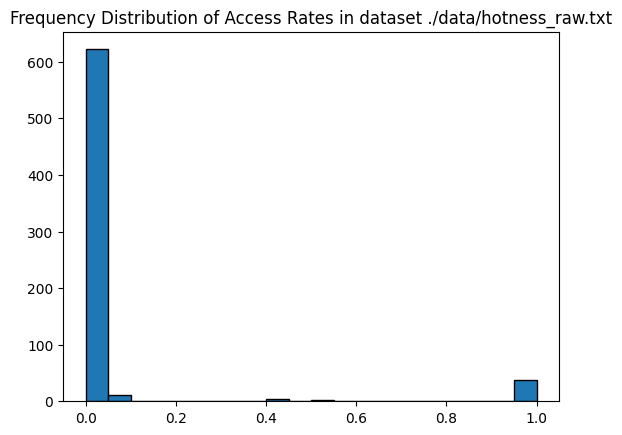

['']
['']
['']
['']
['']
Snapshot of data:  ((tensor([110,  46, 194,  46, 811,   3,   4,  15,   0,  14, 234,   3,   4,  15,
          0,  14,  87,  46, 231,  46, 248,  46, 428,   3,   4,  15,   0,  14,
         87,  46, 231,  46, 248,  46, 812,   3,   4,  15,   0,  14, 565, 223,
         15,   0,  14, 110,  46, 467,  46, 743,   3,   4,  15,   0,  14, 110,
         46,   3, 287,   4,  46, 263,  46, 440,   3,   4,  15,   0,  14,  63,
         46,  57,  46, 185,   3,   4,  15,   0,  14,  63,  46,  57,  46, 183,
          3,   4,  15,   0,  14,  63,  46,  52,  46, 113,   3,   4,  15,   0,
         14,  63,  46, 324,  46, 113,   3,   4,  15,   0,  14,  63,  46, 321,
         46, 113,   3,   4,  15,   0,  14,  63,  46,  57,  46, 202,  46, 252,
          3,   4,  15,   0,  14,  63,  46,  57,  46, 185,   3,   4,  15,   0,
         14,  63,  46,  57,  46, 183,   3,   4,  15,   0,  14,  63,  46, 148,
         46, 113,   3,   4,  15,   0,  14, 245,   3,   4,  15,   0,  14,  30,
        150,  15, 

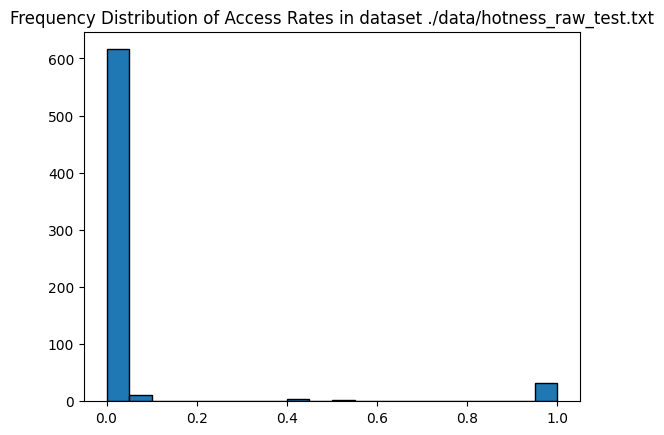

' for x, y in train_dataloader:\n    print(f"Shape of x: {x[0].shape}")\n    print(f"Shape of y: {y.shape}, {y.dtype}")\n '

<Figure size 640x480 with 0 Axes>

In [10]:
# Define Dataset
import random

try:
    tokenizer = tokenizers.Tokenizer.from_file("tokenizer.json")
except:
    build_tokenizer(["data/hotness_raw.txt", "data/hotness_raw_test.txt"])
    tokenizer = tokenizers.Tokenizer.from_file("tokenizer.json")

class MemoryHotnessDataset(Dataset):
    def __init__(self, data_path, transform=None):
        frequency_distribution = []
        with open(data_path, "r") as data_file:
            raw_data = data_file.read()
            allocation_sites = raw_data.split("\n")
            all_tokens = []
            self.data_points = []
            for site in allocation_sites:
                elements = site.split(">|<", 3)
                if len(elements) < 4:
                    print(elements)
                    continue
                average_size = torch.tensor([int(elements[0])]).type(torch.float32)
                if int(elements[1]) == 0:
                    continue
                access_rate = int(elements[2]) / int(elements[1])
                frequency_distribution.append(access_rate)
                stack_trace = elements[3]
                symbols = tokenizer.encode(stack_trace).ids
                symbols = torch.tensor(symbols)
                # turn access_rate into a tensor
                access = torch.tensor([access_rate]).type(torch.float32)
                # print(f"Symbols: {symbols}\nAverage size: {average_size}\nAccess: {access}")
                self.data_points.append(((symbols, average_size), access))
            print("Snapshot of data: ", self.data_points[0])
            plt.hist(frequency_distribution, bins=20, edgecolor="black")
            plt.title(f"Frequency Distribution of Access Rates in dataset {data_path}")
            plt.show()
            plt.clf()
            
    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        return self.data_points[idx][0], self.data_points[idx][1]

training_data = MemoryHotnessDataset("./data/hotness_raw.txt")
train_dataloader = DataLoader(training_data)

test_data = MemoryHotnessDataset("./data/hotness_raw_test.txt")
test_dataloader = DataLoader(test_data)

""" for x, y in train_dataloader:
    print(f"Shape of x: {x[0].shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
 """

In [11]:
# Define Model

class HotnessPredictor(nn.Module):
    def __init__(self, embedding_dim=32, hidden_size=64, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), embedding_dim=embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + 1, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, average_size):
        out = self.embedding(tokens)
        _, out = self.gru(out)
        out = out.squeeze(0)
        out = self.fc(torch.cat((out, average_size), dim=1))
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model = HotnessPredictor().to(device)
print(model)

Using cuda device
HotnessPredictor(
  (embedding): Embedding(1070, 32)
  (gru): GRU(32, 64, batch_first=True)
  (fc): Linear(in_features=65, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
# training

loss = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        tokens, average_size = X
        tokens = tokens.to(device)
        average_size = average_size.to(device)
        y = y.to(device)
        pred = model(tokens, average_size)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (random.random() < 0.01):
            print("Pred: ", pred)
            print("y: ", y)
            print("Loss: ", loss.item())
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return sum(losses) / len(losses)

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, difference = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            tokens, average_size = X
            tokens = tokens.to(device)
            average_size = average_size.to(device)
            y = y.to(device)
            pred = model(tokens, average_size)
            if (random.random() < 0.01):
                print("Pred: ", pred)
                print("y: ", y)
            test_loss += loss_fn(pred, y).item()
            difference += abs(pred - y)
    test_loss /= num_batches
    difference = difference[-1][-1]
    difference /= size
    print(f"Test Error: \n Avg difference: {(difference):>0.01f}, Avg loss: {test_loss:>8f} \n")
    return difference

In [13]:
# actual training

# store training loss and test accuracy over epochs
training_losses = []
test_accuracy = []

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_losses.append(train(train_dataloader, model, loss, optimizer))
    test_accuracy.append(test(test_dataloader, model, loss))
print("Done!")

print(training_losses)
print(test_accuracy)


Epoch 1
-------------------------------
loss: 1.000000  [    0/  678]
loss: 0.000000  [  100/  678]
loss: 0.000000  [  200/  678]
loss: 0.000000  [  300/  678]
Pred:  tensor([[7.5908e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)
y:  tensor([[0.]], device='cuda:0')
Loss:  7.590816153424385e-08
Pred:  tensor([[0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)
y:  tensor([[0.]], device='cuda:0')
Loss:  0.0
loss: 0.000000  [  400/  678]
Pred:  tensor([[5.2866e-29]], device='cuda:0', grad_fn=<SigmoidBackward0>)
y:  tensor([[0.]], device='cuda:0')
Loss:  5.286588021229927e-29
loss: 0.000000  [  500/  678]
Pred:  tensor([[0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)
y:  tensor([[0.]], device='cuda:0')
Loss:  0.0
Pred:  tensor([[0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)
y:  tensor([[0.0192]], device='cuda:0')
Loss:  0.01923076994717121
Pred:  tensor([[8.1947e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)
y:  tensor([[1.]], device='cuda:0')
Loss:  1.0
Pred:  tensor([[

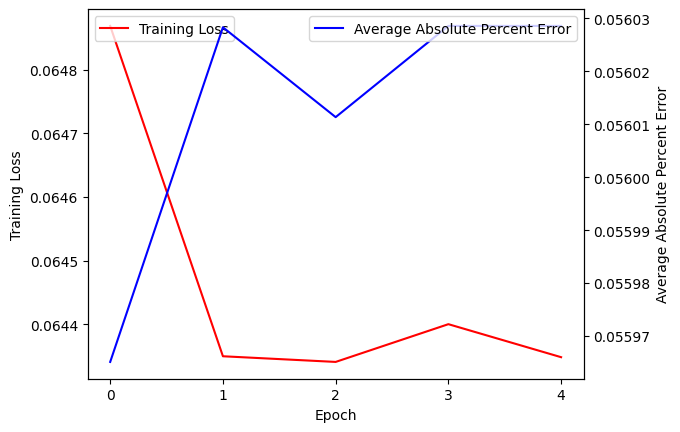

In [14]:
# plot training loss and test accuracy, same graph but different y-axis, give them different colors and y axis labels. Make x axis integer

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
training_losses = torch.tensor(training_losses).cpu()
test_accuracy = torch.tensor(test_accuracy).cpu()
ax1.plot(training_losses, label="Training Loss", color="red")
ax2.plot(test_accuracy, label="Average Absolute Percent Error", color="blue")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("Training Loss")
ax2.set_ylabel("Average Absolute Percent Error")
ax1.set_xlabel("Epoch")
ax1.set_xticks(range(epochs))
plt.show()
